# Engineering the quantum states of light in a Kerr-nonlinear resonator by two-photon driving

In [1]:
%matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qutip
import scipy
import scipy.constants
import scipy.integrate

## Functions

In [2]:
# Hamiltonian as time-dependent and time-independent parts
def H_0_0(N, K):
    """
    Time-independent part of the Kerr hamiltonian.
    """
    a = qutip.destroy(N)
    return -K * (a.dag() * a.dag() * a * a)

def H_0_1(N, Epsilon_p):
    """
    Time-dependent term of the Kerr hamiltonian.
    """
    a = qutip.destroy(N)
    return Epsilon_p * (a.dag())**2 + Epsilon_p.conjugate() * a**2

def H_0_1_coeff(tau):
    """
    Coefficient for the time-dependent term of the Kerr hamiltonian.
    """
    return lambda t, args: (1 - np.exp(-t**4 / tau**4))

# Complete hamiltonian when drive is constant
def H_0(N, K, Epsilon_p):
    """
    2-photon driven KNR hamiltonian in RWA at resonator frequency.
    
    Params:
        - N: Size of the Hilbert space.
        - K: Amplitude of the Kerr nonlinearity (frequency in Hz).
        - Epsilon_p: Amplitude of the 2-photon drive (frequency in Hz).
        
    Returns: The Qobj of the hamiltonian.
    """
    a = qutip.destroy(N)
    return H_0_0(N, K) + H_0_1(N, Epsilon_p)

# Other helpers
def C(alpha, pm):
    """
    Helper for cat states.
    """
    state = qutip.coherent(N, alpha) + pm * qutip.coherent(N, -alpha)
    return state / state.norm()

def purity(rho):
    """
    Compute purity of a density matrix.
    """
    return (rho**2).tr()

def overlap_wigner(state1, state2):
    """
    Compute overlap between wigner functions of state 1 and state 2.
    """
    xvec = np.linspace(-6, 6, 200)
    W1 = qutip.wigner(qutip.Qobj(state1), xvec, xvec)
    W2 = qutip.wigner(qutip.Qobj(state2), xvec, xvec)
    return scipy.integrate.simps(scipy.integrate.simps([[abs(min(W1[i,j], W2[i,j])) for j in range(len(W1[i]))] for i in range(len(W1))], xvec), xvec)

## Global params

In [3]:
N = 40
# Params (expressed as frequencies)
K = 750 * 10**3
Epsilon_p = 4 * K

print("Epsilon_p / K = %.1f." % (Epsilon_p / K))

Epsilon_p / K = 4.0.


## Steady-states

### Steady-states of the two-photon driven KNR hamiltonian

<IPython.core.display.Javascript object>


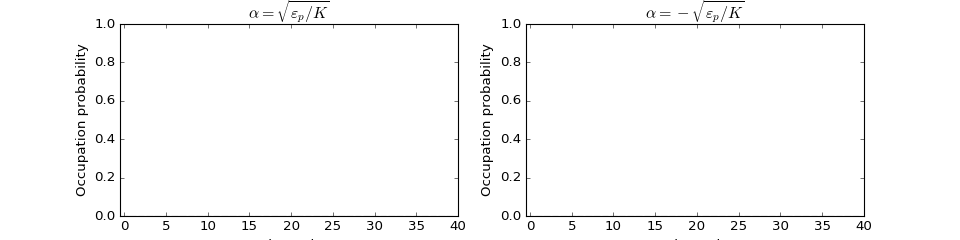

In [4]:
# Expected steady-states of the two-photon driven KNR hamiltonian
H_0_expected_ss = [
    qutip.coherent(N, np.sqrt(Epsilon_p / K)),
    qutip.coherent(N, -np.sqrt(Epsilon_p / K))
]


# Compute steady-states and compare
fig, ax = plt.subplots(1, 2, figsize=(12,3))

qutip.plot_fock_distribution(H_0(N, K, Epsilon_p) * qutip.coherent(N, np.sqrt(Epsilon_p / K)) -
                             Epsilon_p**2 / K * H_0_expected_ss[0],
                             fig=fig, ax=ax[0])
ax[0].set_title(r"$\alpha = \sqrt{\varepsilon_p / K}$")

qutip.plot_fock_distribution(H_0(N, K, Epsilon_p) * qutip.coherent(N, -np.sqrt(Epsilon_p / K)) -
                             Epsilon_p**2 / K * H_0_expected_ss[1],
                             fig=fig, ax=ax[1])
ax[1].set_title(r"$\alpha = -\sqrt{\varepsilon_p / K}$")
fig.show()

<IPython.core.display.Javascript object>


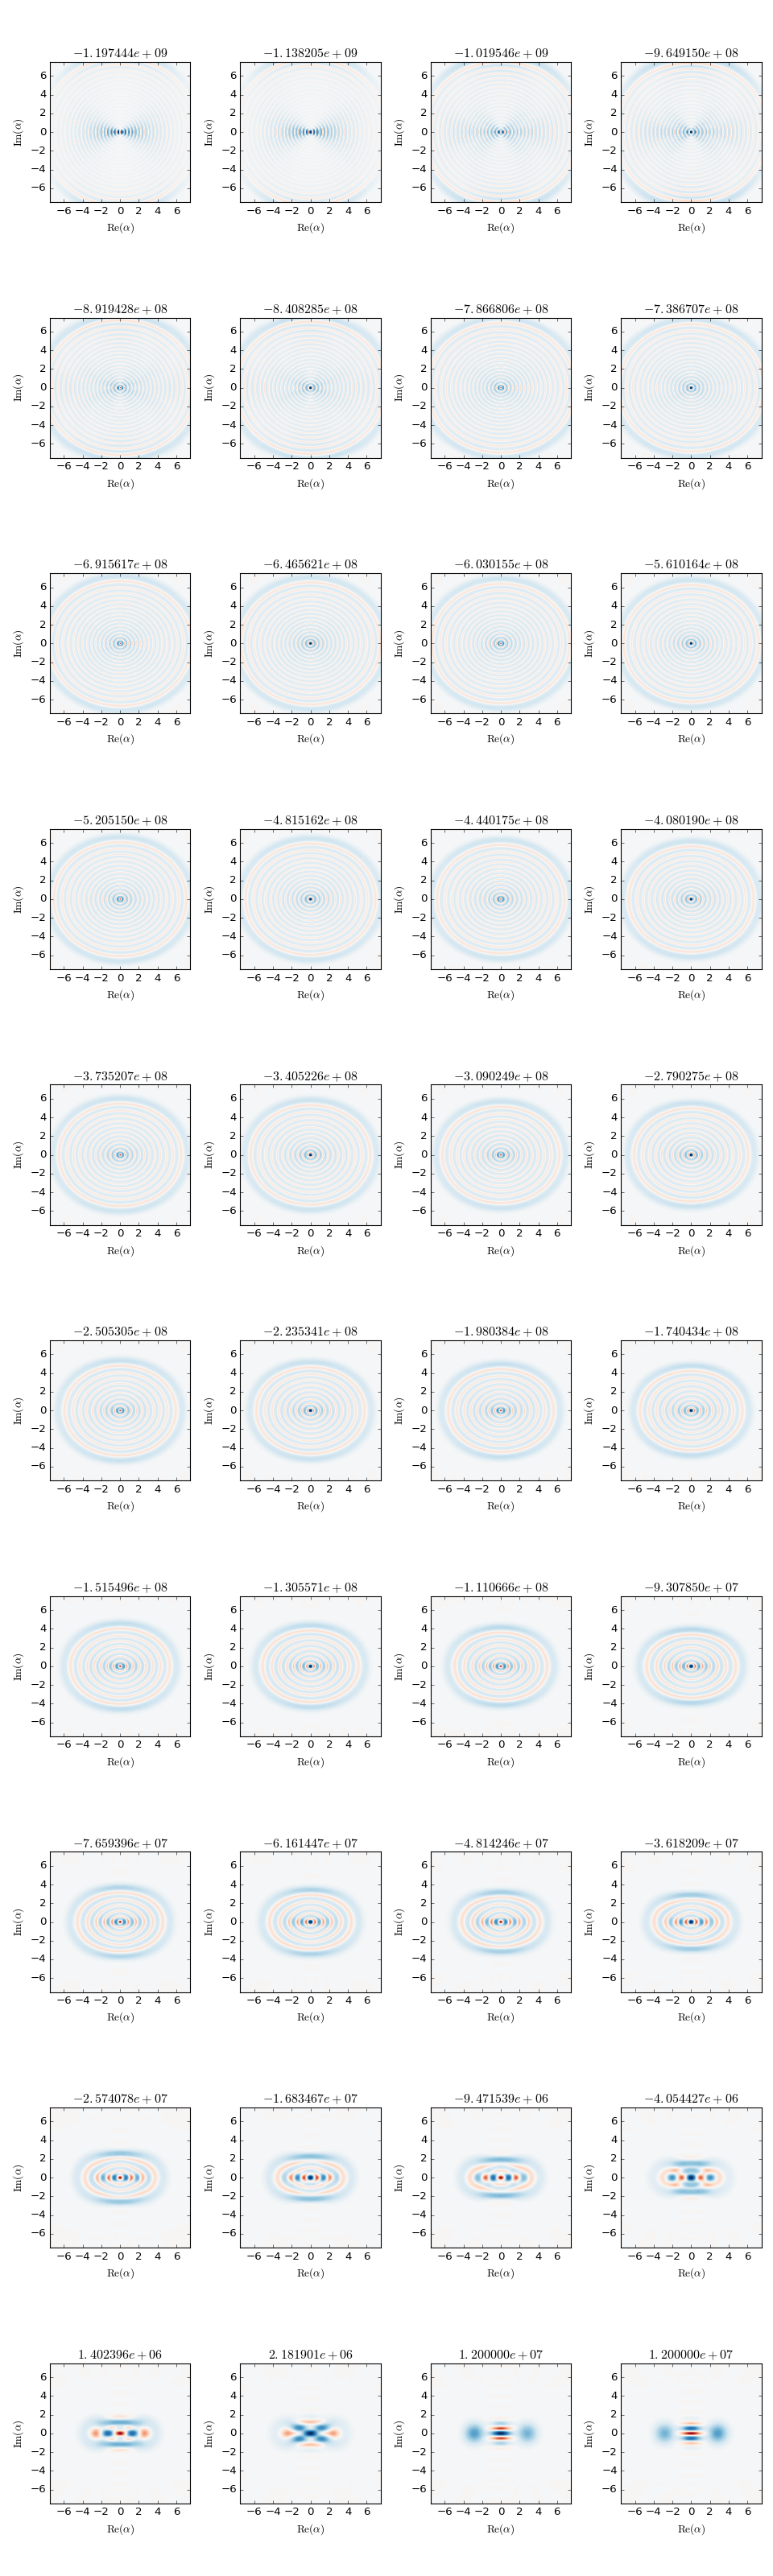

In [5]:
eigval0, eigvec0 = H_0(N, K, Epsilon_p).eigenstates()

fig, axs = plt.subplots(10, 4, figsize=(12, 40))
i = 0
for ax in axs.reshape(-1):
    qutip.plot_wigner(qutip.Qobj(eigvec0[i]), fig=fig, ax=ax)
    ax.set_title(r"$%e$" % eigval0[i])
    ax.set(aspect=1)
    i += 1
fig.tight_layout()
fig.show()

In [32]:
print(overlap_wigner(eigvec0[-1], eigvec0[-1]))
print(overlap_wigner(eigvec0[-2], eigvec0[-2]))
print()
print(overlap_wigner(eigvec0[-1], eigvec0[-2]))
print()
print(overlap_wigner(eigvec0[-1], eigvec0[-3]))
print(overlap_wigner(eigvec0[-2], eigvec0[-3]))
print(overlap_wigner(eigvec0[-3], eigvec0[-3]))
print()
print(overlap_wigner(eigvec0[-1], eigvec0[-4]))
print(overlap_wigner(eigvec0[-2], eigvec0[-4]))
print(overlap_wigner(eigvec0[-4], eigvec0[-4]))

1.58559189501
1.58621980133

1.47871230382

1.1933747147
1.16909030223
1.67909278135

1.24196640987
1.05488784441
1.82261191222


In [6]:
fig, ax = plt.subplots()
cmap = mpl.cm.get_cmap('RdBu')
xvec = np.linspace(-6, 6, 200)
W1 = qutip.wigner(qutip.Qobj(eigvec0[-1]), xvec, xvec)
W2 = qutip.wigner(qutip.Qobj(eigvec0[-3]), xvec, xvec)
wlim = abs(W2).max()
ax.contourf(xvec, xvec, W2, 100, alpha=1, cmap=cmap, norm=mpl.colors.Normalize(-wlim, wlim))
wlim = abs(W1).max()
ax.contourf(xvec, xvec, W1, 100, alpha=0.5, cmap=cmap, norm=mpl.colors.Normalize(-wlim, wlim))
fig.show()

<IPython.core.display.Javascript object>

### With extra single photon loss

In [5]:
kappa = 8 * K
print("K / kappa = %.2f." % (K / kappa))

K / kappa = 0.12.


In [8]:
# And with an extra single photon loss
rho_ss_photon_loss = qutip.steadystate(
    H_0(N, K, Epsilon_p),
    [np.sqrt(kappa) * qutip.destroy(N)])

In [62]:
# Compare with expected results
r_0 = np.power((4 * Epsilon_p**2 - kappa**2 / 4) / (4 * K**2), 1/4)
theta_0 = 0.5 * np.arctan(kappa / np.sqrt(16 * Epsilon_p**2 - kappa**2))
alpha_0 = r_0 * np.exp(-1.0j * theta_0)  # TODO: Why -?
expected_rho_ss = 0.5 * qutip.coherent_dm(N, alpha_0) + 0.5 * qutip.coherent_dm(N, -alpha_0)

<IPython.core.display.Javascript object>


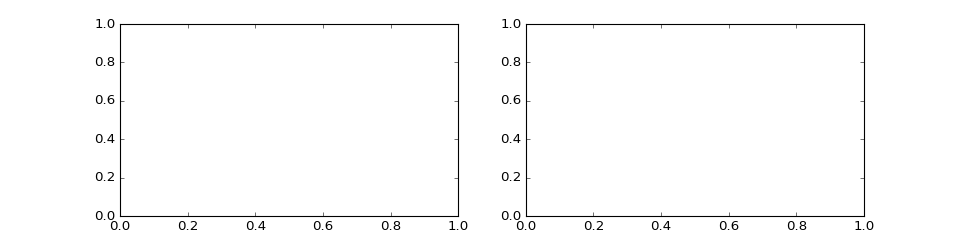

NameError: name 'expected_rho_ss' is not defined

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
qutip.plot_wigner(expected_rho_ss, fig=fig, ax=ax[0])
ax[0].set(aspect=1)
ax[0].set_title("Expected")
qutip.plot_wigner(rho_ss_photon_loss, fig=fig, ax=ax[1])
ax[1].set(aspect=1)
ax[1].set_title("Numerical")
fig.show()

In [ ]:
print("Fidelity is %.2f%%." % (qutip.fidelity(expected_rho_ss, rho_ss_photon_loss) * 100))
print("Purity is %2.f%%." % (purity(rho_ss_photon_loss) * 100))

## Driving to cat state

In [30]:
# Params
tau = 5 / K
tlist = np.linspace(0, 2 * tau, 100)

### $\left|\varphi_0\right> = \left|0\right>$

In [31]:
result = []
for kappa in [K / 250]:
    result.append({
        "kappa": kappa,
        "result": qutip.mesolve([H_0_0(N, K), [H_0_1(N, Epsilon_p), H_0_1_coeff(tau)]],
                                qutip.coherent(N, 2),
                                tlist,
                                [np.sqrt(kappa) * qutip.destroy(N)],
                                [])
            })

<IPython.core.display.Javascript object>


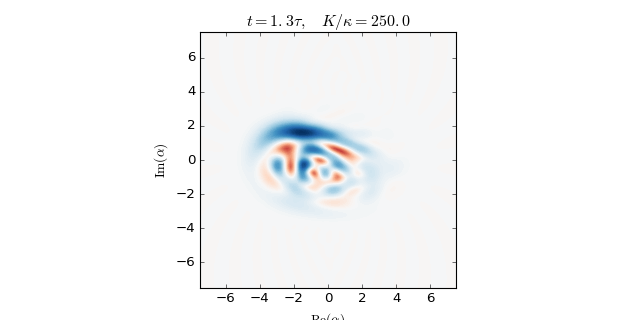

In [33]:
# At t=1.3 tau

# K / kappa = 250
fig, ax = qutip.plot_wigner(result[0]["result"].states[65])
ax.set(aspect=1)
ax.set_title(r"$t=1.3 \tau, \quad K / \kappa=%s$" % (K / result[0]["kappa"]))
fig.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, 1)) for state in result[0]["result"].states])
ax[0].set_xlabel(r"$t \times K / \pi$")
ax[0].set_ylabel(r"Fidelity to $\left|C^+_2\right>$")
ax[0].set_title(r"$\kappa = %s$" % result[0]["kappa"])

ax[1].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, 1)) for state in result[1]["result"].states])
ax[1].set_xlabel(r"$t \times K / \pi$")
ax[1].set_ylabel(r"Fidelity to $\left|C^+_2\right>$")
ax[1].set_title(r"$\kappa = %s$" % result[1]["kappa"])

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, -1)) for state in result[0]["result"].states])
ax[0].set_xlabel(r"$t \times K / \pi$")
ax[0].set_ylabel(r"Fidelity to $\left|C^-_2\right>$")
ax[0].set_title(r"$\kappa = %s$" % result[0]["kappa"])

ax[1].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, -1)) for state in result[1]["result"].states])
ax[1].set_xlabel(r"$t \times K / \pi$")
ax[1].set_ylabel(r"Fidelity to $\left|C^-_2\right>$")
ax[1].set_title(r"$\kappa = %s$" % result[1]["kappa"])

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot([K * t / np.pi for t in tlist], [purity(state) for state in result[0]["result"].states])
ax[0].set_xlabel(r"$t \times K / \pi$")
ax[0].set_ylabel(r"Purity")
ax[0].set_title(r"$\kappa = %s$" % result[0]["kappa"])
ax[0].ticklabel_format(useOffset=False)

ax[1].plot([K * t / np.pi for t in tlist], [purity(state) for state in result[1]["result"].states])
ax[1].set_xlabel(r"$t \times K / \pi$")
ax[1].set_ylabel(r"Purity")
ax[1].set_title(r"$\kappa = %s$" % result[1]["kappa"])

fig.show()

In [ ]:
# Compute fidelity
# kappa = 0
print("Fidelity with C_2^+ for kappa = %s is %.2f%%." %
      (result[0]["kappa"], qutip.fidelity(result[0]["result"].states[65], C(2, 1)) * 100))
print("Fidelity with C_2^- for kappa = %s is %.2f%%." %
      (result[0]["kappa"], qutip.fidelity(result[0]["result"].states[65], C(2, -1)) * 100))

print()

# K / kappa = 250
print("Fidelity with C_2^+ for kappa = %s is %.2f%%." %
      (result[1]["kappa"], qutip.fidelity(result[1]["result"].states[65], C(2, 1)) * 100))
print("Fidelity with C_2^- for kappa = %s is %.2f%%." %
      (result[1]["kappa"], qutip.fidelity(result[1]["result"].states[65], C(2, -1)) * 100))

### $\left|\varphi_0\right> = \left|1\right>$

In [ ]:
result = []
options = qutip.Options()
options.nsteps = 1000000
for kappa in [0, K / 250]:
    result.append({
        "kappa": kappa,
        "result": qutip.mesolve([H_0_0(N, K), [H_0_1(N, Epsilon_p), H_0_1_coeff(tau)]],
                                qutip.fock(N, 1),
                                tlist,
                                [np.sqrt(kappa) * qutip.destroy(N)],
                                [], options=options)
            })

In [ ]:
# At t=1.3 tau

# kappa = 0
fig, ax = plt.subplots(1, 2, figsize=(12,3))
qutip.plot_wigner(result[0]["result"].states[65], fig=fig, ax=ax[0])
ax[0].set(aspect=1)
ax[0].set_title(r"$t=1.3\tau, \quad \kappa=%s$" % (result[0]["kappa"]))

# K / kappa = 250
qutip.plot_wigner(result[1]["result"].states[65], fig=fig, ax=ax[1])
ax[1].set(aspect=1)
ax[1].set_title(r"$t=1.3 \tau, \quad K / \kappa=%s$" % (K / result[1]["kappa"]))
fig.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, -1)) for state in result[0]["result"].states])
ax[0].set_xlabel(r"$t \times K / \pi$")
ax[0].set_ylabel(r"Fidelity to $\left|C^-_2\right>$")
ax[0].set_title(r"$\kappa = %s$" % result[0]["kappa"])

ax[1].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, -1)) for state in result[1]["result"].states])
ax[1].set_xlabel(r"$t \times K / \pi$")
ax[1].set_ylabel(r"Fidelity to $\left|C^-_2\right>$")
ax[1].set_title(r"$\kappa = %s$" % result[1]["kappa"])

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, 1)) for state in result[0]["result"].states])
ax[0].set_xlabel(r"$t \times K / \pi$")
ax[0].set_ylabel(r"Fidelity to $\left|C^+_2\right>$")
ax[0].set_title(r"$\kappa = %s$" % result[0]["kappa"])

ax[1].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, 1)) for state in result[1]["result"].states])
ax[1].set_xlabel(r"$t \times K / \pi$")
ax[1].set_ylabel(r"Fidelity to $\left|C^+_2\right>$")
ax[1].set_title(r"$\kappa = %s$" % result[1]["kappa"])

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot([K * t / np.pi for t in tlist], [purity(state) for state in result[0]["result"].states])
ax[0].set_xlabel(r"$t \times K / \pi$")
ax[0].set_ylabel(r"Purity")
ax[0].set_title(r"$\kappa = %s$" % result[0]["kappa"])
ax[0].ticklabel_format(useOffset=False)

ax[1].plot([K * t / np.pi for t in tlist], [purity(state) for state in result[1]["result"].states])
ax[1].set_xlabel(r"$t \times K / \pi$")
ax[1].set_ylabel(r"Purity")
ax[1].set_title(r"$\kappa = %s$" % result[1]["kappa"])

fig.show()

In [ ]:
# Compute fidelity
# kappa = 0
print("Fidelity with C_2^+ for kappa = %s is %.2f%%." %
      (result[0]["kappa"], qutip.fidelity(result[0]["result"].states[65], C(2, 1)) * 100))
print("Fidelity with C_2^- for kappa = %s is %.2f%%." %
      (result[0]["kappa"], qutip.fidelity(result[0]["result"].states[65], C(2, -1)) * 100))

print()

# K / kappa = 250
print("Fidelity with C_2^+ for kappa = %s is %.2f%%." %
      (result[1]["kappa"], qutip.fidelity(result[1]["result"].states[65], C(2, 1)) * 100))
print("Fidelity with C_2^- for kappa = %s is %.2f%%." %
      (result[1]["kappa"], qutip.fidelity(result[1]["result"].states[65], C(2, -1)) * 100))

## Evolution of a cat state in time

In [13]:
phi_0 = C(2, 1)  # Initial state
kappa = K / 20

#### Without 2-photon driving

In [ ]:
# Without 2-photon driving
result = qutip.mesolve(H_0(N, K, 0),
                       phi_0,
                       tlist,
                       [np.sqrt(kappa) * qutip.destroy(N)],
                       [])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
qutip.plot_wigner(result.states[0], fig=fig, ax=ax[0])
ax[0].set(aspect=1)
ax[0].set_title(r"$t=0, \quad K / \kappa=%s$" % (K / kappa))

qutip.plot_wigner(result.states[4], fig=fig, ax=ax[1])
ax[1].set(aspect=1)
ax[1].set_title(r"$t=\pi / (8K), \quad K / \kappa=%s$" % (K / kappa))

qutip.plot_wigner(result.states[31], fig=fig, ax=ax[2])
ax[2].set(aspect=1)
ax[2].set_title(r"$t=\pi / K, \quad K / \kappa=%s$" % (K / kappa))

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, 1)) for state in result.states])
ax[0].set_xlabel(r"$t \times K / \pi$")
ax[0].set_ylabel(r"Fidelity to $\left|C^+_2\right>$")

ax[1].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, -1)) for state in result.states])
ax[1].set_xlabel(r"$t \times K / \pi$")
ax[1].set_ylabel(r"Fidelity to $\left|C^-_2\right>$")

fig.show()

In [ ]:
fig, ax = plt.subplots()

ax.plot([K * t / np.pi for t in tlist], [purity(state) for state in result.states])
ax.set_xlabel(r"$t \times K / \pi$")
ax.set_ylabel(r"Purity")

fig.show()

#### With 2-photon driving

In [16]:
# With 2-photon driving
result = qutip.mesolve(H_0(N, K, Epsilon_p),
                       phi_0,
                       tlist,
                       [np.sqrt(kappa) * qutip.destroy(N)],
                       [])

<IPython.core.display.Javascript object>


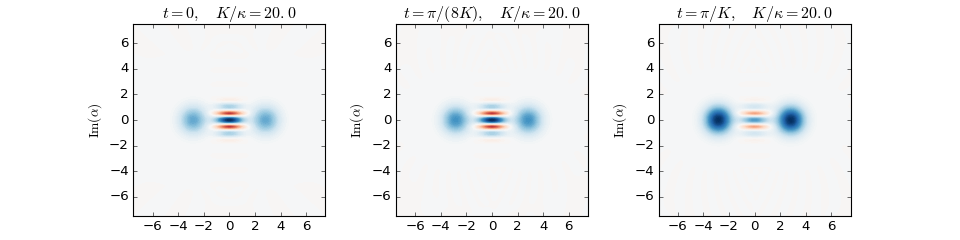

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
qutip.plot_wigner(result.states[0], fig=fig, ax=ax[0])
ax[0].set(aspect=1)
ax[0].set_title(r"$t=0, \quad K / \kappa=%s$" % (K / kappa))

qutip.plot_wigner(result.states[4], fig=fig, ax=ax[1])
ax[1].set(aspect=1)
ax[1].set_title(r"$t=\pi / (8K), \quad K / \kappa=%s$" % (K / kappa))

qutip.plot_wigner(result.states[31], fig=fig, ax=ax[2])
ax[2].set(aspect=1)
ax[2].set_title(r"$t=\pi / K, \quad K / \kappa=%s$" % (K / kappa))

fig.show()

<IPython.core.display.Javascript object>


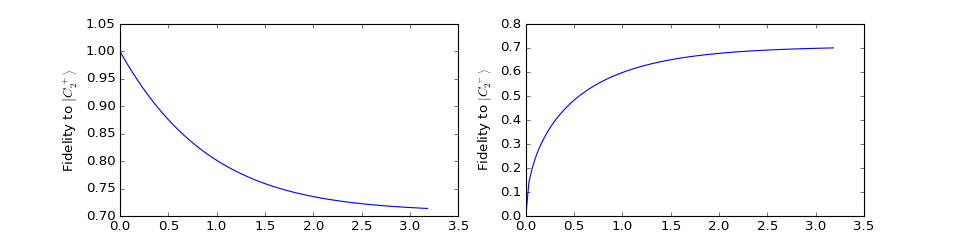

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, 1)) for state in result.states])
ax[0].set_xlabel(r"$t \times K / \pi$")
ax[0].set_ylabel(r"Fidelity to $\left|C^+_2\right>$")

ax[1].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, -1)) for state in result.states])
ax[1].set_xlabel(r"$t \times K / \pi$")
ax[1].set_ylabel(r"Fidelity to $\left|C^-_2\right>$")

fig.show()

<IPython.core.display.Javascript object>


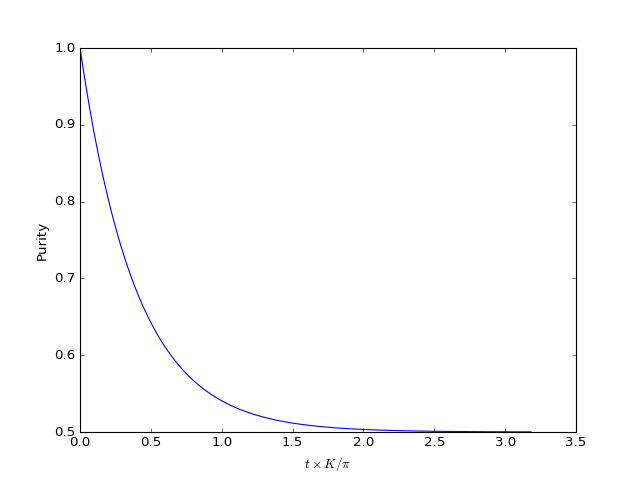

In [19]:
fig, ax = plt.subplots()

ax.plot([K * t / np.pi for t in tlist], [purity(state) for state in result.states])
ax.set_xlabel(r"$t \times K / \pi$")
ax.set_ylabel(r"Purity")

fig.show()

Taking out the $a \rho a^{\dagger}$ term, which introduces bitflips:

In [ ]:
# TODO
# Assemble lindbladian
lindbladian = qutip.liouvillian(H_0(N, K, Epsilon_p), [np.sqrt(kappa) * qutip.destroy(N)])
# Take out the bit-flip part
lindbladian -= kappa * qutip.spre(qutip.destroy(N)) * qutip.spost(qutip.create(N))

result = qutip.mesolve(lindbladian,
                       C(2 * np.exp(0.1j), 1),
                       tlist,
                       [],
                       [])

##### Dephasing

In [14]:
# With 2-photon driving and initial dephasing
result = qutip.mesolve(H_0(N, K, Epsilon_p),
                       C(2 * np.exp(0.1j), 1),
                       tlist,
                       [np.sqrt(kappa) * qutip.destroy(N)],
                       [])

<IPython.core.display.Javascript object>


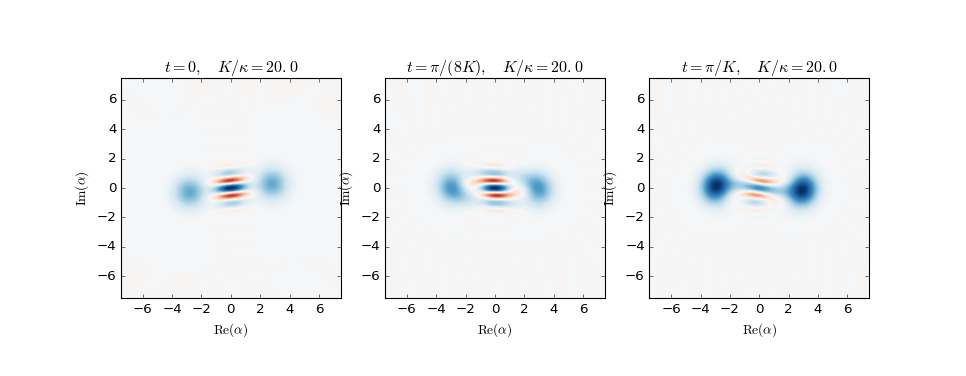

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
qutip.plot_wigner(result.states[0], fig=fig, ax=ax[0])
ax[0].set(aspect=1)
ax[0].set_title(r"$t=0, \quad K / \kappa=%s$" % (K / kappa))

qutip.plot_wigner(result.states[4], fig=fig, ax=ax[1])
ax[1].set(aspect=1)
ax[1].set_title(r"$t=\pi / (8K), \quad K / \kappa=%s$" % (K / kappa))

qutip.plot_wigner(result.states[31], fig=fig, ax=ax[2])
ax[2].set(aspect=1)
ax[2].set_title(r"$t=\pi / K, \quad K / \kappa=%s$" % (K / kappa))

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, 1)) for state in result.states])
ax[0].set_xlabel(r"$t \times K / \pi$")
ax[0].set_ylabel(r"Fidelity to $\left|C^+_2\right>$")

ax[1].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, -1)) for state in result.states])
ax[1].set_xlabel(r"$t \times K / \pi$")
ax[1].set_ylabel(r"Fidelity to $\left|C^-_2\right>$")

fig.show()

In [ ]:
fig, ax = plt.subplots()

ax.plot([K * t / np.pi for t in tlist], [purity(state) for state in result.states])
ax.set_xlabel(r"$t \times K / \pi$")
ax.set_ylabel(r"Purity")

fig.show()

##### Amplitude

In [ ]:
# With 2-photon driving and initial dephasing
result = qutip.mesolve(H_0(N, K, Epsilon_p),
                       C(2 * 0.9, 1),
                       tlist,
                       [np.sqrt(kappa) * qutip.destroy(N)],
                       [])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
qutip.plot_wigner(result.states[0], fig=fig, ax=ax[0])
ax[0].set(aspect=1)
ax[0].set_title(r"$t=0, \quad K / \kappa=%s$" % (K / kappa))

qutip.plot_wigner(result.states[4], fig=fig, ax=ax[1])
ax[1].set(aspect=1)
ax[1].set_title(r"$t=\pi / (8K), \quad K / \kappa=%s$" % (K / kappa))

qutip.plot_wigner(result.states[31], fig=fig, ax=ax[2])
ax[2].set(aspect=1)
ax[2].set_title(r"$t=\pi / K, \quad K / \kappa=%s$" % (K / kappa))

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, 1)) for state in result.states])
ax[0].set_xlabel(r"$t \times K / \pi$")
ax[0].set_ylabel(r"Fidelity to $\left|C^+_2\right>$")

ax[1].plot([K * t / np.pi for t in tlist], [qutip.fidelity(state, C(2, -1)) for state in result.states])
ax[1].set_xlabel(r"$t \times K / \pi$")
ax[1].set_ylabel(r"Fidelity to $\left|C^-_2\right>$")

fig.show()

In [ ]:
fig, ax = plt.subplots()

ax.plot([K * t / np.pi for t in tlist], [(state**2).tr() for state in result.states])
ax.set_xlabel(r"$t \times K / \pi$")
ax.set_ylabel("Purity")

fig.show()

# Scratchpad